In [1]:
import visa
import rigol1000z
import jupyter_beeper
from tqdm import tqdm
import numpy as np
import keyboard
import time
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rm = visa.ResourceManager()
print('VISA Resources: ', rm.list_resources())

VISA Resources:  ('USB0::0x1AB1::0x04CE::DS1ZA181908193::INSTR',)


In [3]:
scope = rm.open_resource(rm.list_resources()[0])
rigolScope = rigol1000z.Rigol1000z(scope)
print('ID: ', rigolScope.get_id())

ID:  RIGOL TECHNOLOGIES,DS1104Z,DS1ZA181908193,00.04.04



In [4]:
class BodePlot_Point:
    def __init__(self, vin, vout, delay, frequency):
        self.vin = vin
        self.vout = vout
        self.delay = delay
        self.frequency = frequency
        
        self.phase = (delay * frequency) * 2 * np.pi
        self.H = 20 * np.log10(vout / vin)

def bode_save(ls, path):
    vins = []
    vouts = []
    delays = []
    frequencies = []
    Hs = []
    phases = []
    for l in ls:
        vins += [x.vin for x in l]
        vouts += [x.vout for x in l]
        delays += [x.delay for x in l]
        frequencies += [x.frequency for x in l]
        Hs += [x.H for x in l]
        phases += [x.phase for x in l]
    
    data = {'vin': vins, 'vout': vouts, 'delay': delays, 'frequency': frequencies, 'H': Hs, 'phase':phases}

    df = pd.DataFrame(data,columns= ['vin', 'vout', 'delay', 'frequency', 'H', 'phase'])
    
    df.to_csv(path, index=False)
    
    return df

def bode_plot(ls):
    frequencies = []
    Hs = []
    phases = []
    for l in ls:
        frequencies += [x.frequency for x in l]
        Hs += [x.H for x in l]
        phases += [x.phase for x in l]
    
    plt.subplot(2, 1, 1)
    plt.plot(frequencies, Hs, '.')
    plt.title('Bode Plot')
    plt.xscale('log')
    plt.ylabel('$H$')

    plt.subplot(2, 1, 2)
    plt.plot(frequencies, phases, '.')
    plt.xlabel('$f$ (Hz)')
    plt.ylabel('$\\phi$')
    plt.xscale('log')

    plt.show()
    
        
def captureBodePlot(scope, num, time_total_ms = 4500, time_setup_ms = 1900):
    '''
    Captures the amplitude of signals on channel 1 (Vin) and 2 (Vout), the time delay 
    between the signals, and the frequency of the signal on Channel 1. It repeats the 
    measurement 'num' times, every 'time_total_ms' milliseconds, with 'time_setup_ms'
    milliseconds given to change the frequency setting in the signal generator 
    connected to the circuit. After the setup time a short beep is heard and the 
    measurements statistics are cleared and the following measurement begins. When each
    measurement finished, a longer and higher pitch beep is heard.
    
    In order to stop the measurement before the completion of 'num' iterations and still 
    retrieve the measurements already made, press 'q' at any time.
    
    Args:
        num (int): The number of times to repeat the measurements
        time_total_ms (int): The time (in milliseconds) between measurements. Default 
                             is 4000 (4 seconds).
        time_setup_ms (int): The time between the ending of a measurement, and the begining
                             of the next measurement (time to change the frequency setting of 
                             the generator). Default is 1400 (1.4 seconds).
    
    Returns:
        
        np.array() of BodePlot_Points with the measurements.
    '''
    
    beeper = jupyter_beeper.Beeper()
    
    scope.visa_write(':MEASure:COUNter:SOURce CHANnel1')
    scope.visa_write(':MEASure:SETup:DSA CHANnel1')
    scope.visa_write(':MEASure:SETup:DSB CHANnel2')
    scope.visa_write(':MEASure:STATistic:DISPlay ON')
    scope.visa_write(':MEASure:STATistic:MODE DIFFerence')
    scope.visa_write(':MEASure:STATistic:ITEM VPP,CHANnel1')
    scope.visa_write(':MEASure:STATistic:ITEM VPP,CHANnel2')
    scope.visa_write(':MEASure:STATistic:ITEM RDELay')
    
    data = []
    
    mills_time = lambda: int(round(time.time() * 1000))
    numPointsTaken = 0
    lastMeasurement = mills_time()
    inSetup = True
    with tqdm(total=num) as pbar:
        while True:
            try:
                if keyboard.is_pressed('q'):
                    break
                else:
                    timeNow = mills_time()
                    if inSetup:
                        if timeNow >= lastMeasurement + time_setup_ms:
                            inSetup = False
                            scope.visa_write(':MEASure:STATistic:RESet')
                            beeper.beep(900, 0.2)
                    elif timeNow >= lastMeasurement + time_total_ms:
                        vin = float(scope.visa_ask(':MEASure:STATistic:ITEM? AVERages,VPP,CHANnel1'))
                        vout = float(scope.visa_ask(':MEASure:STATistic:ITEM? AVERages,VPP,CHANnel2'))
                        delay = float(scope.visa_ask(':MEASure:STATistic:ITEM? AVERages,RDELay'))
                        freq = float(scope.visa_ask(':MEASure:COUNter:VALue?'))
                        
                        data += [BodePlot_Point(vin, vout, delay, freq)]

                        pbar.update(1)
                        numPointsTaken += 1
                        if numPointsTaken == num:
                            beeper.beep(1200, 1.3, blocking=True)
                            break
                        else:
                            beeper.beep(1200, 0.4)
                        lastMeasurement = mills_time()
                        inSetup=True
            except:
                break
    
    return data

In [6]:
data_rlc_white = captureBodePlot(rigolScope, 200)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [15:05<00:00,  4.53s/it]


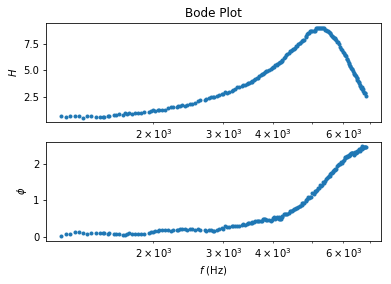

In [7]:
bode_save([data_rlc_white], 'example/data_rlc_white.csv');
bode_plot([data_rlc_white])

In [ ]:
scope.close()